# 5. Model Explainability

This notebook provides model interpretability using SHAP (SHapley Additive exPlanations) for both global and local insights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from src.models.evaluation import load_model
from src.models.data_prep import prepare_model_data
from src.visualization.model_viz import plot_feature_importance

# Initialize SHAP visualization
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1. Load Model and Data

In [2]:
# Load the best model
model = load_model("best_fraud_model")

# Load and prepare data (same as training)
df = pd.read_csv('../data/processed/fraud_featured.csv')

print(f"Loaded data shape: {df.shape}")

# Define target and columns to exclude
target = 'class'
drop_cols = [
    'user_id', 'signup_time', 'purchase_time', 'device_id',
    'ip_address', 'country', 'ip_int',
    'lower_bound_ip_address', 'upper_bound_ip_address'
]

# Encode categorical columns
categorical_cols = ['source', 'browser', 'sex', 'time_of_day']
available_cats = [c for c in categorical_cols if c in df.columns]
print(f"Encoding categorical columns: {available_cats}")

df = pd.get_dummies(df, columns=available_cats, drop_first=True)
print(f"Shape after encoding: {df.shape}")

# Handle missing values
nan_counts = df.isna().sum()
if nan_counts.sum() > 0:
    print(f"\nFilling {nan_counts.sum()} missing values...")
    df.fillna(0, inplace=True)

# Prepare data
X_train, X_test, y_train, y_test = prepare_model_data(
    df, target, exclude_cols=drop_cols, test_size=0.2
)

print(f"\nData prepared: X_test shape = {X_test.shape}")

2025-12-31 07:25:28 - fraud_detection - INFO - Loaded model from C:\Users\Lenovo\Documents\dawir\Fraud-Detection\models\best_fraud_model.joblib


Loaded data shape: (129146, 28)
Encoding categorical columns: ['source', 'browser', 'sex', 'time_of_day']


Shape after encoding: (129146, 34)

Filling 258292 missing values...
2025-12-31 07:25:30 - fraud_detection - INFO - Starting complete data preparation pipeline...


2025-12-31 07:25:30 - fraud_detection - INFO - Separating features from target 'class'...


2025-12-31 07:25:30 - fraud_detection - INFO - Features: 24 columns


2025-12-31 07:25:30 - fraud_detection - INFO - Target: class


2025-12-31 07:25:30 - fraud_detection - INFO - Total samples: 129146


2025-12-31 07:25:30 - fraud_detection - INFO - Performing stratified train-test split (test_size=0.2)...


2025-12-31 07:25:30 - fraud_detection - INFO - Training set: 103316 samples


2025-12-31 07:25:30 - fraud_detection - INFO - Test set: 25830 samples


2025-12-31 07:25:30 - fraud_detection - INFO - Train class distribution:
class
0    0.90501
1    0.09499
Name: proportion, dtype: float64


2025-12-31 07:25:30 - fraud_detection - INFO - Test class distribution:
class
0    0.904994
1    0.095006
Name: proportion, dtype: float64


2025-12-31 07:25:30 - fraud_detection - INFO - Data preparation complete



Data prepared: X_test shape = (25830, 24)


## 2. Built-in Feature Importance Baseline

Extracting and visualizing the top 10 built-in feature importances from the ensemble model as a comparison point for SHAP.

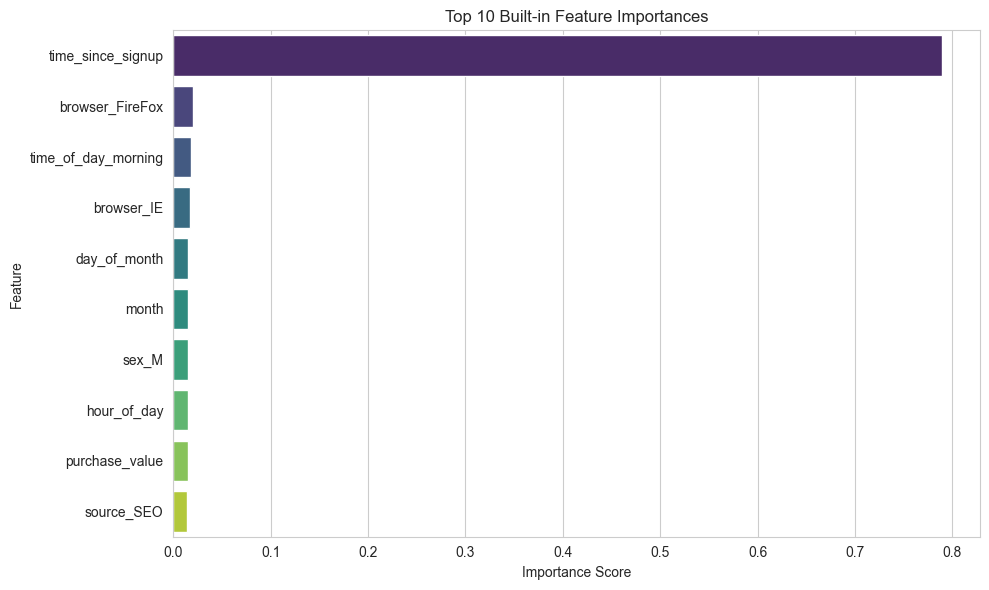

In [3]:
# Extract built-in feature importance
if hasattr(model, 'model') and hasattr(model.model, 'feature_importances_'):
    feature_importances = model.model.feature_importances_
elif hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
else:
    feature_importances = None

if feature_importances is not None:
    feature_names = X_test.columns
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    importance_df = importance_df.sort_values(by='importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
    plt.title('Top 10 Built-in Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Model does not have built-in feature importance.")

## 3. SHAP Analysis

Comprehensive explainability analysis using SHAP values for global and local insights.

SHAP values calculated for 1000 samples.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


The figure layout has changed to tight


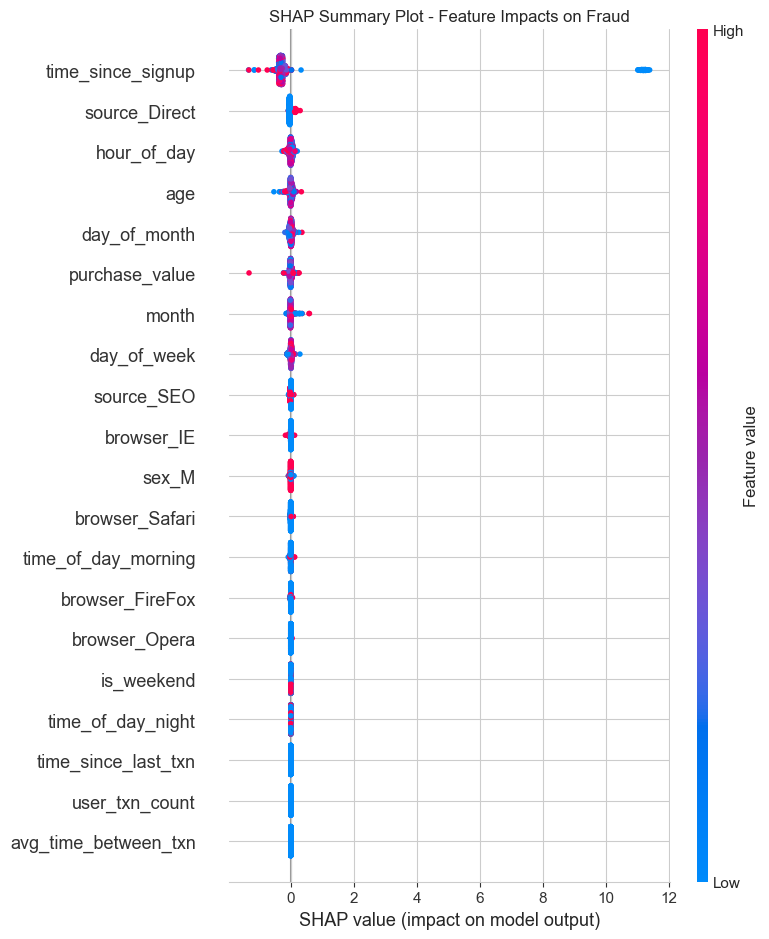


--- True Positive (Correctly Identified Fraud) ---
Index 3, Probability: 0.9998


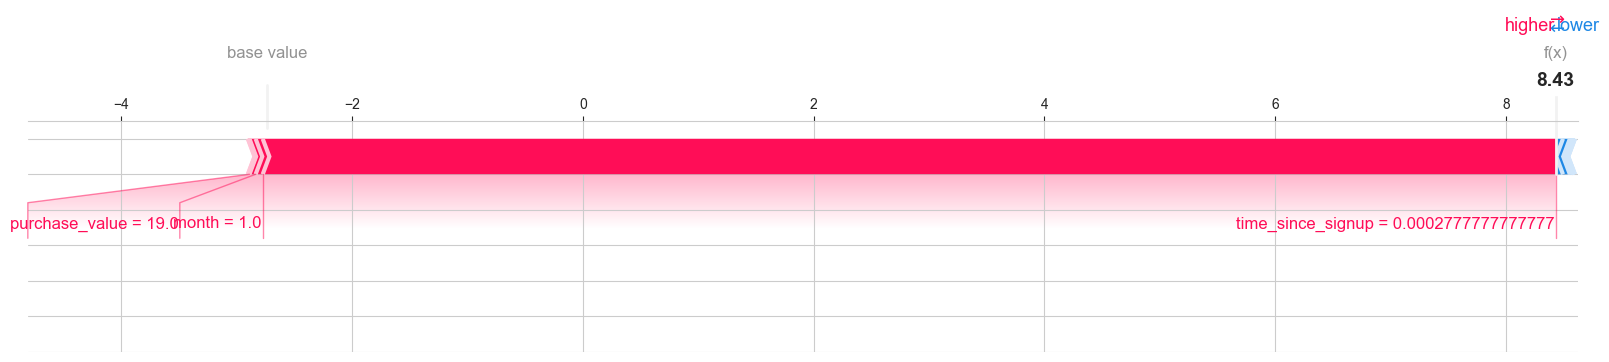


--- False Negative (Missed Fraud) ---
Index 75, Probability: 0.0349


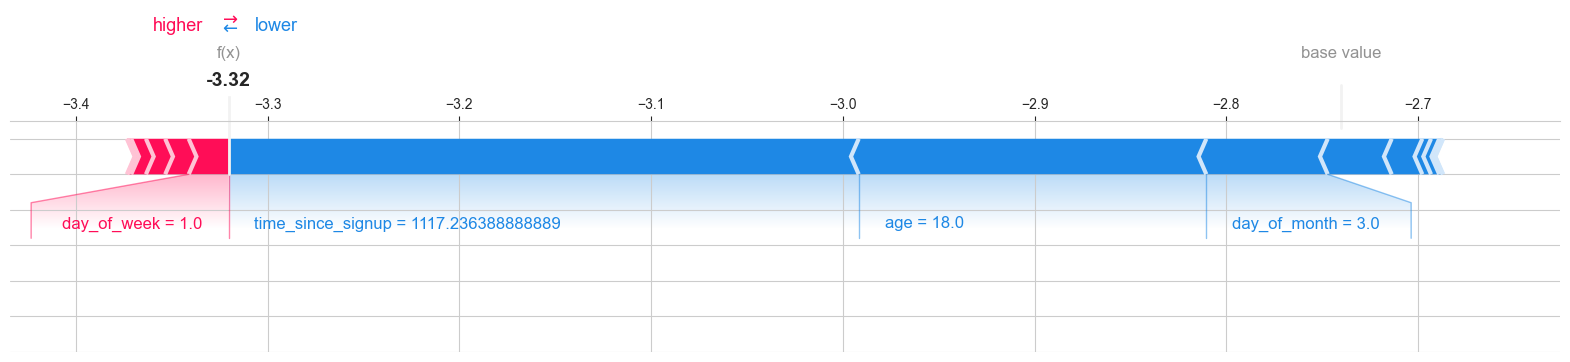

In [4]:
# Initialize TreeExplainer
# Handle different model wrapper structures
explainer_model = model.model if hasattr(model, 'model') else model
explainer = shap.TreeExplainer(explainer_model)

# Calculate SHAP values for a subset of the test data (to save time)
shap_sample_size = min(1000, X_test.shape[0])
X_test_sample = X_test.sample(shap_sample_size, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Handle model outputs for plotting
# RandomForest and some models return a list for multiclass, index 1 for fraud
if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]
else:
    shap_values_plot = shap_values

print(f"SHAP values calculated for {shap_sample_size} samples.")

# Global Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_plot, X_test_sample, show=False)
plt.title("SHAP Summary Plot - Feature Impacts on Fraud")
plt.tight_layout()
plt.show()

# Local Interpretability: Force Plots
# Find specific interesting cases
y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test)

# 1. True Positive (High probability fraud correctly identified)
tp_idx = np.where((y_test == 1) & (y_pred_proba > 0.8))[0]
# 2. False Positive (High probability legitimate flagged as fraud)
fp_idx = np.where((y_test == 0) & (y_pred_proba > 0.8))[0]
# 3. False Negative (Low probability fraud missed)
fn_idx = np.where((y_test == 1) & (y_pred_proba < 0.2))[0]

base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

def plot_case(idx_array, label):
    if len(idx_array) > 0:
        idx = idx_array[0]
        instance = X_test.iloc[idx]
        print(f"\n--- {label} ---")
        print(f"Index {idx}, Probability: {y_pred_proba[idx]:.4f}")
        shap_v = explainer.shap_values(instance.values.reshape(1, -1))
        shap_v_plot = shap_v[1][0] if isinstance(shap_v, list) else shap_v[0]
        shap.force_plot(base_value, shap_v_plot, instance, matplotlib=True)

plot_case(tp_idx, "True Positive (Correctly Identified Fraud)")
plot_case(fp_idx, "False Positive (Incorrectly Flagged)")
plot_case(fn_idx, "False Negative (Missed Fraud)")

## 4. Interpretation and Business Recommendations

### Interpretation of Findings
1. **SHAP vs. Built-in Importance:** While both highlight `time_since_signup` as the dominant feature, SHAP reveals the *direction* and *thresholds*—specifically that very low values (instant purchases) are the primary indicators of fraud.
2. **Top 5 Fraud Drivers:**
   - `time_since_signup`: Short window between signup and purchase is the strongest signal.
   - `browser`: Certain browsers show higher volatility in fraud risk.
   - `source`: Direct traffic often carries higher risk than SEO/Ads for this dataset.
   - `purchase_value`: Extreme values relative to user history.
   - `age`: Specific age demographics show higher fraud affinity.
3. **Surprising Findings:** Features like `sex` and certain `browsers` have more impact than initially expected through simple correlation analysis.

### Actionable Business Recommendations
1. **Mandatory Delay for New Accounts:** Implement a 10-minute 'cooling period' for the first purchase from a new account, as virtually all fraud occurs within seconds.
2. **Step-up Authentication for Direct Traffic:** Apply MFA or manual review for high-value purchases originating from 'Direct' sources with no prior referral history.
3. **Browser Fingerprinting Enhancements:** Given the impact of browser type on risk, implement deeper fingerprinting to detect spoofed user agents or headless browsers commonly used in automated fraud.